In [ ]:
# 과제 피드백
# Confusion Matrix가 [[105   2] [ 43   4]] 로 출력되는 것을 보아 분류가 전혀 되고 있지 않기 때문에 하이퍼파라미터 튜닝으로 해결.
# CrossEntropyLoss를 썼었는데, 이진분류니까 binary 분류용 Loss인 BCE를 사용하도록 수정.

# binary classification에서는 BCEWithLogitsLoss() + 마지막 레이어에 Sigmoid를 생략하거나
# Sigmoid + BCELoss 둘 중 하나만 사용하면 됨.
# CrossEntropyLoss는 softmax 기반 다중분류용임.

# 여기서 BCE란? Binary Cross Entropy의 약자이며, 이진 분류(Binary Classification) 문제에서 주로 사용하는 손실 함수이다.
# 그리고 만약 BCEWithLogitsLoss()를 쓰면 sigmoid+binary cross entropy를 한번에 처리하게 되는 것이다.

In [1]:
from sklearn.datasets import load_breast_cancer
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
import seaborn as sn

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay

In [3]:
import tensorflow as tf
from tensorflow import keras

df = pd.read_csv("D:/diabetes.csv")
df

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1


In [4]:
# imbalanced 확인
df['Outcome'].value_counts()

0    500
1    268
Name: Outcome, dtype: int64

In [5]:
# 데이터 분할 X
X=df.drop('Outcome',axis=1)
X.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,6,148,72,35,0,33.6,0.627,50
1,1,85,66,29,0,26.6,0.351,31
2,8,183,64,0,0,23.3,0.672,32
3,1,89,66,23,94,28.1,0.167,21
4,0,137,40,35,168,43.1,2.288,33


In [6]:
# Standardize the data
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [7]:
# 데이터 분할 y
y=df['Outcome']
y.value_counts()

0    500
1    268
Name: Outcome, dtype: int64

In [8]:
# 원 핫 인코딩
#Y = pd.get_dummies(y).values
#Y

# 정수 인코딩 (원-핫 말고)
Y = y.values  # 0 또는 1의 정수값을 그대로 유지

In [9]:
from sklearn.model_selection import train_test_split
X_train,X_test, y_train,y_test = train_test_split(X,Y,test_size=0.2,random_state=0) 

In [10]:
X_train.shape,X_test.shape, y_train.shape, y_test.shape

((614, 8), (154, 8), (614,), (154,))

In [11]:
# 텐서 변환
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).view(-1,1)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32).view(-1,1)

In [12]:
# 데이터로더
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

In [13]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([614, 8]),
 torch.Size([154, 8]),
 torch.Size([614, 1]),
 torch.Size([154, 1]))

In [14]:
# 모델 정의
class DiabetesModel(nn.Module):
    def __init__(self):
        super(DiabetesModel, self).__init__()
        self.fc1 = nn.Linear(8, 16)
        self.fc2 = nn.Linear(16, 32)
        self.fc3 = nn.Linear(32, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))  # Sigmoid로 확률 출력
        return x

model = DiabetesModel()

In [15]:
# binary classification이니까 Sigmoid + BCELoss 사용
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [16]:
# 학습
train_losses = []
test_accuracies = []

num_epochs = 50
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    train_losses.append(running_loss / len(train_loader))

    # 테스트
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            preds = (outputs > 0.5).float()
            total += labels.size(0)
            correct += (preds == labels).sum().item()
    accuracy = 100 * correct / total
    test_accuracies.append(accuracy)

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {train_losses[-1]:.4f}, Accuracy: {accuracy:.2f}%")

print("Training complete.")

Epoch 1/50, Loss: 0.6933, Accuracy: 62.99%
Epoch 2/50, Loss: 0.6677, Accuracy: 75.32%
Epoch 3/50, Loss: 0.6419, Accuracy: 75.32%
Epoch 4/50, Loss: 0.6110, Accuracy: 75.32%
Epoch 5/50, Loss: 0.5841, Accuracy: 75.32%
Epoch 6/50, Loss: 0.5514, Accuracy: 76.62%
Epoch 7/50, Loss: 0.5336, Accuracy: 76.62%
Epoch 8/50, Loss: 0.5114, Accuracy: 75.97%
Epoch 9/50, Loss: 0.5106, Accuracy: 76.62%
Epoch 10/50, Loss: 0.4964, Accuracy: 77.27%
Epoch 11/50, Loss: 0.4918, Accuracy: 78.57%
Epoch 12/50, Loss: 0.4775, Accuracy: 81.17%
Epoch 13/50, Loss: 0.4709, Accuracy: 80.52%
Epoch 14/50, Loss: 0.4793, Accuracy: 81.17%
Epoch 15/50, Loss: 0.4650, Accuracy: 80.52%
Epoch 16/50, Loss: 0.4755, Accuracy: 81.82%
Epoch 17/50, Loss: 0.4556, Accuracy: 81.82%
Epoch 18/50, Loss: 0.4579, Accuracy: 81.82%
Epoch 19/50, Loss: 0.4668, Accuracy: 80.52%
Epoch 20/50, Loss: 0.4438, Accuracy: 81.82%
Epoch 21/50, Loss: 0.4402, Accuracy: 81.82%
Epoch 22/50, Loss: 0.4648, Accuracy: 81.82%
Epoch 23/50, Loss: 0.4448, Accuracy: 81.1

In [17]:
# 최종 평가
model.eval()
all_preds = []
all_targets = []
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        preds = (outputs > 0.5).float()
        all_preds.extend(preds.cpu().numpy())
        all_targets.extend(labels.cpu().numpy())

# 평가지표 계산
all_preds = np.array(all_preds).reshape(-1)
all_targets = np.array(all_targets).reshape(-1)

cm = confusion_matrix(all_targets, all_preds)
f1 = f1_score(all_targets, all_preds)
precision = precision_score(all_targets, all_preds)
recall = recall_score(all_targets, all_preds)
tn, fp, fn, tp = cm.ravel()
specificity = tn / (tn + fp)

print(f'\nConfusion Matrix:\n{cm}')
print(f'F1 Score: {f1:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'Specificity: {specificity:.2f}')


Confusion Matrix:
[[93 14]
 [17 30]]
F1 Score: 0.66
Precision: 0.68
Recall: 0.64
Specificity: 0.87


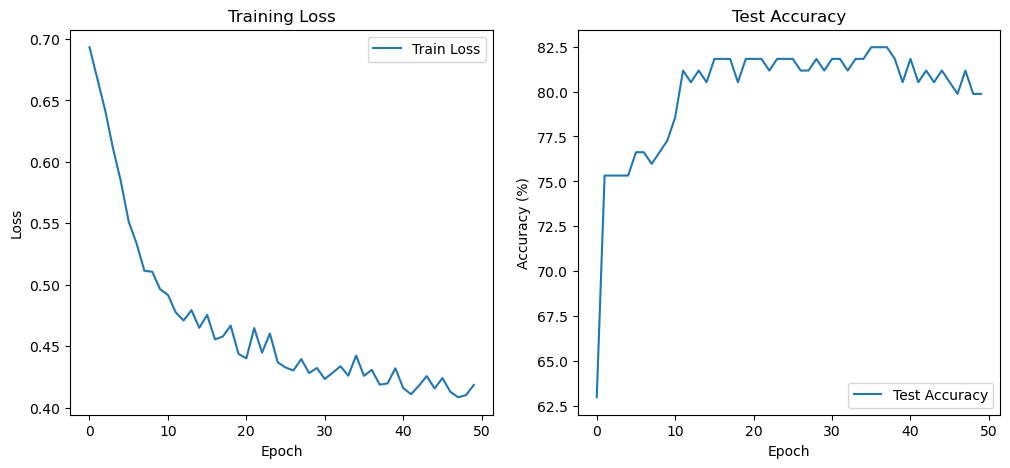

In [18]:
# 학습곡선 시각화
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(train_losses, label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Test Accuracy')
plt.legend()

plt.show()